## Subset Selection Methods

In [1]:
# install.packages("ISLR")
library(ISLR) #安裝需要的package

In [2]:
data(Hitters) #取出資料

In [3]:
names(Hitters) #看資料的欄位名稱

[1] "AtBat"     "Hits"      "HmRun"     "Runs"      "RBI"       "Walks"    
 [7] "Years"     "CAtBat"    "CHits"     "CHmRun"    "CRuns"     "CRBI"     
[13] "CWalks"    "League"    "Division"  "PutOuts"   "Assists"   "Errors"   
[19] "Salary"    "NewLeague"

In [4]:
dim(Hitters) #看資料的行、列數 

[1] 322  20

In [5]:
Hitters = na.omit(Hitters) #將資料中有缺失值的列刪除

In [6]:
dim(Hitters) #刪除缺失值後重新查看資料的行、列數

[1] 263  20

In [7]:
sum(is.na(Hitters )) #檢查是否還有缺失值尚未刪除

[1] 0

### Best Subset Selection

$\bullet$ 以Salary作為反應變數，執行regsubsets()配適模型

$\bullet$ nvmax表示我們所希望得到最佳模型的變數個數

$\bullet$ 此函數將會配適每一種變數個數的最佳模型

In [8]:
# install.packages("leaps")
library(leaps) #安裝需要的package 

In [9]:
regfit.full=regsubsets(Salary~.,data=Hitters ,nvmax =19)

將模型的結果存起來，模型結果裡會包含不同準則的值

In [10]:
reg.summary=summary(regfit.full)

試著取出每一種變數個數的最佳模型的Adjusted Rsquare，取出的結果依照順序為變數數量為1~變數數量為19的最佳模型的Adjusted Rsquare

In [11]:
reg.summary$adjr2

[1] 0.3188503 0.4208024 0.4450753 0.4672734 0.4808971 0.4972001 0.5007849
 [8] 0.5137083 0.5180572 0.5222606 0.5225706 0.5217245 0.5206736 0.5195431
[15] 0.5178661 0.5162219 0.5144464 0.5126097 0.5106270

視覺化不同準則在每一種變數個數的模型的值，紅點所對應的Y軸表示在這個準則中最好的值，對應的X軸則為該準則認為最佳的變數個數

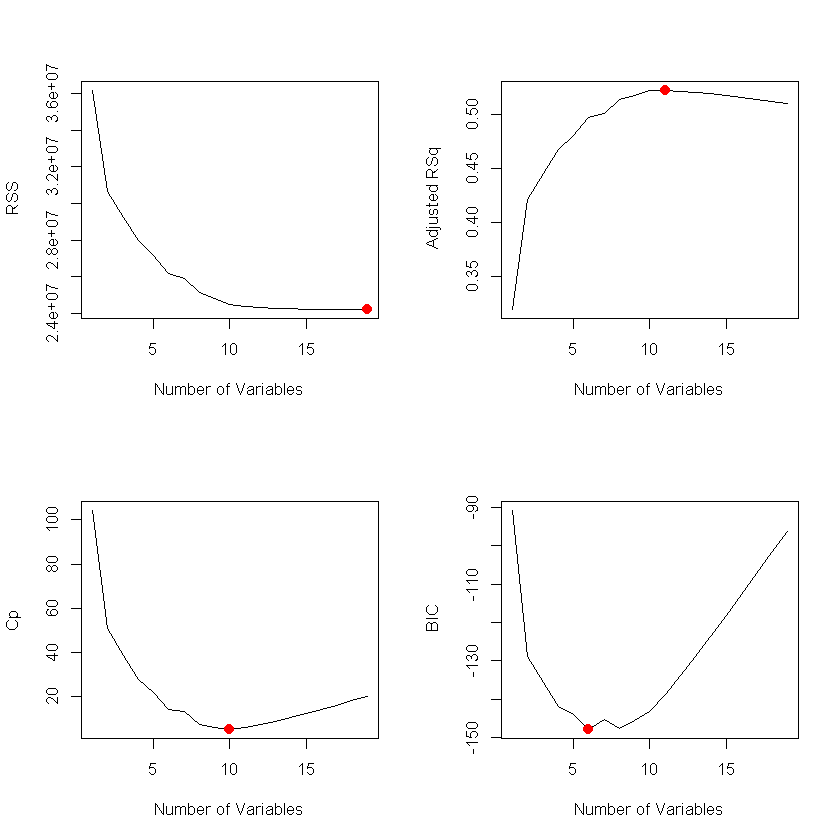

In [12]:
par(mfrow =c(2,2))

plot(reg.summary$rss ,xlab=" Number of Variables ",ylab=" RSS",type="l")
points(which.min(reg.summary$rss), reg.summary$rss[which.min(reg.summary$rss)], col ="red",cex =2, pch =20)

plot(reg.summary$adjr2 ,xlab =" Number of Variables ", ylab=" Adjusted RSq",type="l")
points(which.max(reg.summary$adjr2), reg.summary$adjr2[which.max(reg.summary$adjr2)], col ="red",cex =2, pch =20)

plot(reg.summary$cp ,xlab ="Number of Variables",ylab="Cp",type='l')
points(which.min(reg.summary$cp), reg.summary$cp[which.min(reg.summary$cp)], col ="red",cex =2, pch =20)

plot(reg.summary$bic ,xlab="Number of Variables",ylab=" BIC",type='l')
points(which.min(reg.summary$bic), reg.summary$bic[which.min(reg.summary$bic)], col =" red",cex =2, pch =20)

### Forward Selection & Backward Selection

$\bullet$ 和Best subset selection所使用的函數相同

$\bullet$ 若想用Forward Selection，將參數method指定為"forward"

$\bullet$ 同樣可用nvmax決定想要的最佳模型的變數數量

In [13]:
regfit.fwd=regsubsets(Salary~.,data=Hitters, nvmax =19, method ="forward")

$\bullet$ 若想用Backward Selection，將參數method指定為"backward"

$\bullet$ 同樣可用nvmax決定想要的最佳模型的變數數量

In [14]:
regfit.bwd=regsubsets(Salary~.,data=Hitters ,nvmax =19,method ="backward")

### The Lasso

$\bullet$ 利用model.matrix()建立x資料集，當我們需要建立具有交互作用或者次方項的變數時，即可使用
model.matrix()

$\bullet$ 由於Hitters資料中有類別型的變數，而我們接下來要用的glmnet()函數無法處理變數中具有類別型變數的情況，此時利用model.matrix()就可將類別型變數轉換為dummy variable

In [15]:
x=model.matrix(Salary~.,Hitters)[,-1]
y=Hitters$Salary

In [16]:
# install.packages("glmnet")
library(glmnet) #安裝需要的package

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18



將資料分為訓練集和測試集

In [17]:
set.seed (1)
train=sample(1:nrow(x), nrow(x)/2)
test=(-train)
y.test=y[test]

以glmnet()實現The Lasso方法，要放的參數有：

$\bullet$ x:不含反應變數的資料集

$\bullet$ y:反應變數

$\bullet$ alpha:設為alpha=1

$\bullet$ lambda: tuning parameter，可以一次放一個數列的lambda，若沒有指定lambda，函數也有預設一定範圍的lambda

在這裡我們指定$\lambda$的範圍介在$10^{-2}\sim10^2$之間

In [18]:
grid =10^seq(10,-2,length =100) 

配適The Lasso模型

In [19]:
lasso.mod =glmnet(x[train ,],y[train],alpha =1, lambda =grid)

利用cross validation選擇最佳的tuning parameter $\lambda$

$\bullet$ cv.glmnet():配適進行cross validation的The Lasso模型

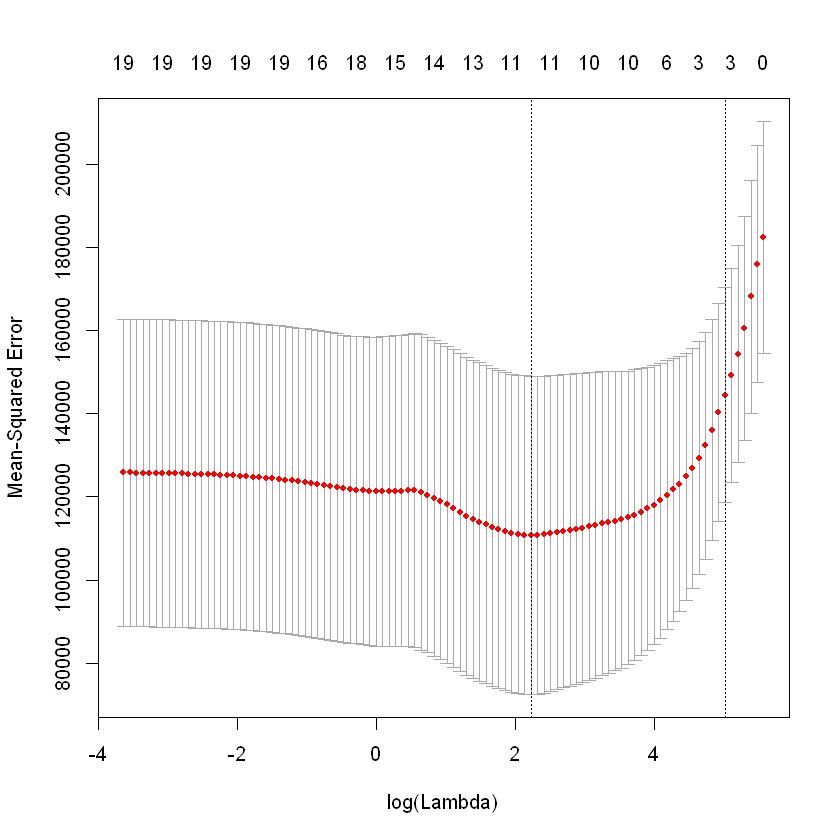

In [20]:
set.seed(1)
cv.out = cv.glmnet(x[train ,],y[train],alpha =1) 
plot(cv.out) #畫出在不同的lambda之下模型的MSE

In [21]:
bestlam = cv.out$lambda.min #使模型的MSE最小的lambda，也就是我們想要的lambda
lasso.pred= predict(lasso.mod,s=bestlam ,newx=x[test ,]) #將The Lasso模型的lambda設定為我們選出的lambda，丟入測試集資料進行預測
mean((lasso.pred-y.test)^2) #test MSE

[1] 143673.6

In [22]:
lasso.coef=predict(cv.out ,type ="coefficients",s=bestlam)[1:20 ,] #代入最佳lambda的The Lasso模型的係數

In [23]:
lasso.coef

(Intercept)        AtBat         Hits        HmRun         Runs          RBI 
 119.8417677    0.0000000    0.0000000    3.4239422    0.0000000    0.0000000 
       Walks        Years       CAtBat        CHits       CHmRun        CRuns 
   4.0487555  -11.8252121    0.0000000    0.2052751    0.9106627    0.0000000 
        CRBI       CWalks      LeagueN    DivisionW      PutOuts      Assists 
   0.3846064    0.0000000   46.8403552 -135.3002087    0.1164027    0.1401224 
      Errors   NewLeagueN 
   0.0000000    0.0000000

用全部的x資料集重新建立The Lasso模型，並代入藉由cross validation所選出的lambda得到模型的係數

In [24]:
out=glmnet(x,y,alpha =1, lambda =grid)
lasso.coef=predict(out ,type ="coefficients",s=bestlam)[1:20 ,]
lasso.coef

(Intercept)         AtBat          Hits         HmRun          Runs 
   1.27479059   -0.05497143    2.18034583    0.00000000    0.00000000 
          RBI         Walks         Years        CAtBat         CHits 
   0.00000000    2.29192406   -0.33806109    0.00000000    0.00000000 
       CHmRun         CRuns          CRBI        CWalks       LeagueN 
   0.02825013    0.21628385    0.41712537    0.00000000   20.28615023 
    DivisionW       PutOuts       Assists        Errors    NewLeagueN 
-116.16755870    0.23752385    0.00000000   -0.85629148    0.00000000